# OpenML dataset: **_airfoil_self_noise_**
## **Description**
**Data Description**:

NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.

It comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

The task is to predict the (scaled) self noise.
**Attribute Description**:

1. *frequency* - in Hertzs
2. *angle_of_attack* - in degrees
3. *chord_length* - in meters
4. *free_stream_velocity* - in meters per second
5. *displacement_thickness* - in meters
6. *sound_pressure* - in decibels (target feature)

In [9]:
import openml

dataset = openml.datasets.get_dataset(44957)
X, y, cat_atr_mask, names = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

In [10]:
X.head()

,frequency,angle_of_attack,chord_length,free_stream_velocity,displacement_thickness
0,800.0,0.0,0.3048,71.3,0.002663
1,1000.0,0.0,0.3048,71.3,0.002663
2,1250.0,0.0,0.3048,71.3,0.002663
3,1600.0,0.0,0.3048,71.3,0.002663
4,2000.0,0.0,0.3048,71.3,0.002663


In [11]:
y.head()

0    126.201
1    125.201
2    125.951
3    127.591
4    127.461
Name: sound_pressure, dtype: float64

In [12]:
X.shape

(1503, 5)

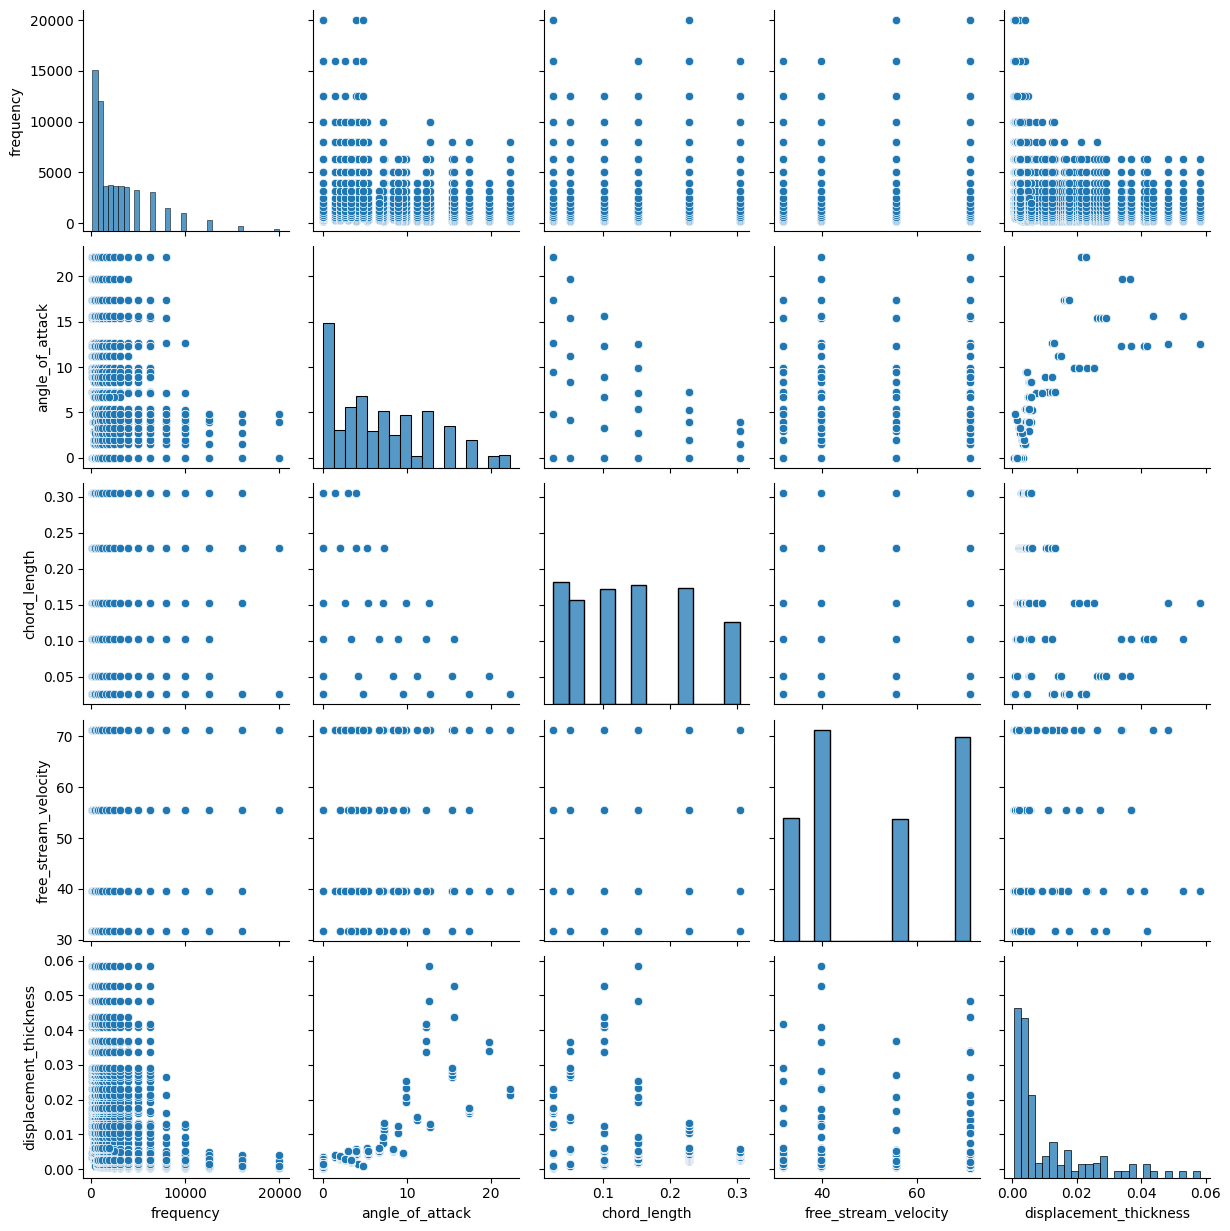

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(X)

In [14]:
import pandas as pd


labeled_data = pd.concat([X, y], axis=1)
labeled_data.head()

,frequency,angle_of_attack,chord_length,free_stream_velocity,displacement_thickness,sound_pressure
0,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1000.0,0.0,0.3048,71.3,0.002663,125.201
2,1250.0,0.0,0.3048,71.3,0.002663,125.951
3,1600.0,0.0,0.3048,71.3,0.002663,127.591
4,2000.0,0.0,0.3048,71.3,0.002663,127.461


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'frequency'),
  Text(1.5, 0, 'angle_of_attack'),
  Text(2.5, 0, 'chord_length'),
  Text(3.5, 0, 'free_stream_velocity'),
  Text(4.5, 0, 'displacement_thickness'),
  Text(5.5, 0, 'sound_pressure')])

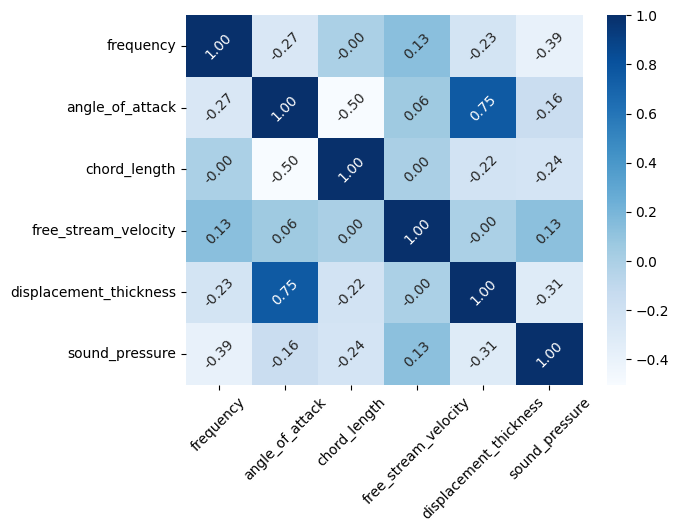

In [15]:
corr = labeled_data.corr()


sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', annot_kws={"rotation": 45})
plt.xticks(rotation=45) 


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_prep = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.25, random_state=42)

In [23]:
from tabpfn import TabPFNRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import warnings
warnings.filterwarnings('ignore')


models = {
    'TabPFN': TabPFNRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    stop = time.time()
    print(f'{name} training time: {stop - start:.2f}s')

TabPFN training time: 0.84s
XGBoost training time: 0.16s
LightGBM training time: 0.09s
CatBoost training time: 2.64s


In [24]:
import numpy as np
results = {}

def calculate_aic(n, mse, k):
    return n * np.log(mse) + 2 * k

def calculate_bic(n, mse, k):
    return n * np.log(mse) + k * np.log(n)

n = len(y_test)
k = X_test.shape[1]

for name, model in models.items():
    start = time.time()
    y_pred = model.predict(X_test)
    stop = time.time()
    print(f'{name} prediction time: {stop - start:.2f}s')
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    aic = calculate_aic(n, mse, k)
    bic = calculate_bic(n, mse, k)
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R^2': r2, 'AIC': aic, 'BIC': bic}
    print(f'{name} MSE: {mse}, RMSE: {rmse}, AIC: {aic}, BIC: {bic}')

TabPFN prediction time: 105.70s
TabPFN MSE: 0.9614414310656602, RMSE: 0.980531198415257, AIC: -4.784932856282694, BIC: 14.863012860666778
XGBoost prediction time: 0.01s
XGBoost MSE: 2.076616315569629, RMSE: 1.4410469512023643, AIC: 284.7581639439108, BIC: 304.4061096608603
LightGBM prediction time: 0.01s
LightGBM MSE: 3.5282109078507817, RMSE: 1.878353243628786, AIC: 484.05738497795716, BIC: 503.70533069490665
CatBoost prediction time: 0.01s
CatBoost MSE: 2.2808889335668425, RMSE: 1.5102612136868385, AIC: 320.0365340470068, BIC: 339.6844797639563


In [ ]:
results_df = pd.DataFrame(results)


,TabPFN,XGBoost,LightGBM,CatBoost
MSE,0.961441,2.076616,3.528211,2.280889
RMSE,0.980531,1.441047,1.878353,1.510261
R^2,0.979838,0.956452,0.926011,0.952168
AIC,-4.784933,284.758164,484.057385,320.036534
BIC,14.863013,304.406110,503.705331,339.684480


In [28]:
results_df

,TabPFN,XGBoost,LightGBM,CatBoost
MSE,0.961441,2.076616,3.528211,2.280889
RMSE,0.980531,1.441047,1.878353,1.510261
R^2,0.979838,0.956452,0.926011,0.952168
AIC,-4.784933,284.758164,484.057385,320.036534
BIC,14.863013,304.406110,503.705331,339.684480


TabPFN comes out victorious.